In [6]:
%pip install datasets

                                              0.0/515.2 kB ? eta -:--:--
     --                                      30.7/515.2 kB 1.3 MB/s eta 0:00:01
     -----                                 71.7/515.2 kB 653.6 kB/s eta 0:00:01
     ------                                92.2/515.2 kB 871.5 kB/s eta 0:00:01
     ----------------                       225.3/515.2 kB 1.3 MB/s eta 0:00:01
     ---------------------                  286.7/515.2 kB 1.2 MB/s eta 0:00:01
     ------------------------------------   491.5/515.2 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 515.2/515.2 kB 1.7 MB/s eta 0:00:00
                                              0.0/27.5 MB ? eta -:--:--
                                              0.5/27.5 MB 15.4 MB/s eta 0:00:02
     -                                        0.8/27.5 MB 8.8 MB/s eta 0:00:04
     --                                       1.6/27.5 MB 11.0 MB/s eta 0:00:03
     ----                                     3.0/27.5 M


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from huggingface_hub import login
from datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import random
import base64
import io
from PIL import Image
import os
from tqdm import tqdm
from datasets import load_from_disk
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import optimizers



c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


login(token="add your token here!!") # Paste your specific token here

c:\Users\PCD\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("xuxuxuxuxu/SurgWound")

Generating test split: 100%|██████████| 1116/1116 [00:00<00:00, 2743.35 examples/s]


In [10]:
# Save the dataset to a folder named "SurgWound_data"
ds.save_to_disk("SurgWound_data")

Saving the dataset (1/1 shards): 100%|██████████| 1116/1116 [00:00<00:00, 11636.25 examples/s]


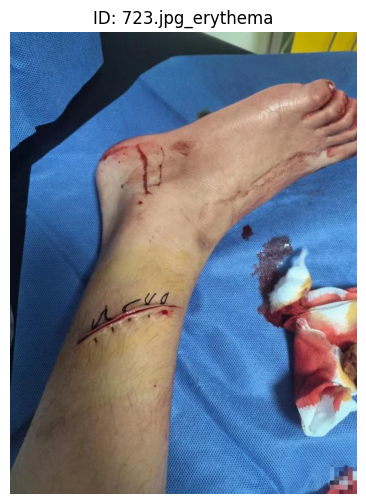

--- Example #3148 ---
Question:      Has erythema developed in this surgical wound?
Options:       ['Non-existent', 'Existent', 'Uncertain']
Correct Answer: Non-existent


In [ ]:


# 1. Get the example
index = random.randint(0, len(ds["train"]) - 1)
item = ds["train"][index]

# 2. Decode the Base64 String to an Image
image_string = item["image"]

# Remove header if present (e.g., "data:image/png;base64,...")
if "," in image_string:
    image_string = image_string.split(",", 1)[1]

# Convert string -> bytes -> image
image_bytes = base64.b64decode(image_string)
image = Image.open(io.BytesIO(image_bytes))

# 3. Show the Image
plt.figure(figsize=(6, 6))
plt.imshow(image)  # Pass the converted 'image' object here
plt.axis("off")
plt.title(f"ID: {item['id']}")
plt.show()

# 4. Print the VQA Data
print(f"--- Example #{index} ---")
print(f"Question:      {item['question']}")
print(f"Options:       {item['options']}")
print(f"Correct Answer: {item['answer']}")



In [ ]:


ds = load_from_disk("SurgWound_data")
# 1. Setup output directory (Using a new name to avoid confusion)
OUTPUT_ROOT = "SurgWound_Cleaned" 
os.makedirs(OUTPUT_ROOT, exist_ok=True)

def process_split_filtered(dataset_split, split_name):
    print(f"Processing {split_name} split...")
    
    images_dir = os.path.join(OUTPUT_ROOT, split_name, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    metadata_rows = []

    for item in tqdm(dataset_split):
        image_id = item['id']
        
        # --- FILTERING LOGIC ---
        # 1. Skip if it is a Report
        if "report" in image_id or item.get('task_type') == 'report_generation':
            continue
            
        # 2. (Optional) If you ONLY want Exudate and Erythema, uncomment these lines:
        # valid_types = ["erythema", "exudate_type"]
        # if not any(t in image_id for t in valid_types):
        #     continue
        # -----------------------

        image_filename = f"{image_id}.jpg"
        save_path = os.path.join(images_dir, image_filename)
        
        try:
            # Decode & Save Image
            img_str = item['image']
            if "," in img_str: img_str = img_str.split(",", 1)[1]
            
            img_bytes = base64.b64decode(img_str)
            image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            image.save(save_path)
            
            # Save Metadata
            row = {
                "image_id": image_id,
                "filename": os.path.join(split_name, "images", image_filename),
                "question": item['question'],
                "answer": item['answer'],
                "task_type": item['task_type'] # Helpful to verify later
            }
            metadata_rows.append(row)
            
        except Exception as e:
            print(f"Error processing ID {image_id}: {e}")

    # Save CSV
    df = pd.DataFrame(metadata_rows)
    csv_path = os.path.join(OUTPUT_ROOT, f"{split_name}_data.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} records to {csv_path} (Reports excluded)")

# 2. Run the function
# (Assumes 'ds' is still loaded. If not, reload it: ds = load_from_disk("SurgWound_data"))
if 'train' in ds: process_split_filtered(ds['train'], 'train')
if 'validation' in ds: process_split_filtered(ds['validation'], 'validation')
if 'test' in ds: process_split_filtered(ds['test'], 'test')

print("\n✅ Done! Use the 'SurgWound_Cleaned' folder for your models.")

Processing train split...


100%|██████████| 3915/3915 [00:20<00:00, 188.92it/s]


Saved 3435 records to SurgWound_Cleaned\train_data.csv (Reports excluded)
Processing validation split...


100%|██████████| 569/569 [00:02<00:00, 215.15it/s]


Saved 500 records to SurgWound_Cleaned\validation_data.csv (Reports excluded)
Processing test split...


100%|██████████| 1116/1116 [00:05<00:00, 216.41it/s]

Saved 979 records to SurgWound_Cleaned\test_data.csv (Reports excluded)

✅ Done! Use the 'SurgWound_Cleaned' folder for your models.


In [ ]:

# Load your new CSV
df = pd.read_csv("SurgWound_Cleaned/train_data.csv")

# Count how many times each question appears
print(df["question"].value_counts().head(20))

question
What is the healing status of this surgical healing?             480
What is the infection risk assessment of this surgical wound?    480
What is the urgency level of this surgical wound?                480
Has erythema developed in this surgical wound?                   463
What is the exudate type of this surgical wound?                 437
Has edema developed in this surgical wound?                      378
What is the wound location of this surgical wound?               368
What is the closure method of this surgical wound?               349
Name: count, dtype: int64


✅ Loaded 3435 rows from SurgWound_Cleaned/train_data.csv

--- ERYTHEMA STATS ---
answer
Non-existent    334
Existent        129
Name: count, dtype: int64

Total Erythema Images: 463


--- EXUDATE TYPE STATS ---
answer
Non-existent    367
Serous           26
Sanguineous      24
Purulent         12
Seropurulent      8
Name: count, dtype: int64

Total Exudate Images: 437


C:\Users\PCD\AppData\Local\Temp\ipykernel_24220\880350829.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ery_counts.index, y=ery_counts.values, palette="Reds")
C:\Users\PCD\AppData\Local\Temp\ipykernel_24220\880350829.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=exu_counts.index, y=exu_counts.values, palette="Blues")


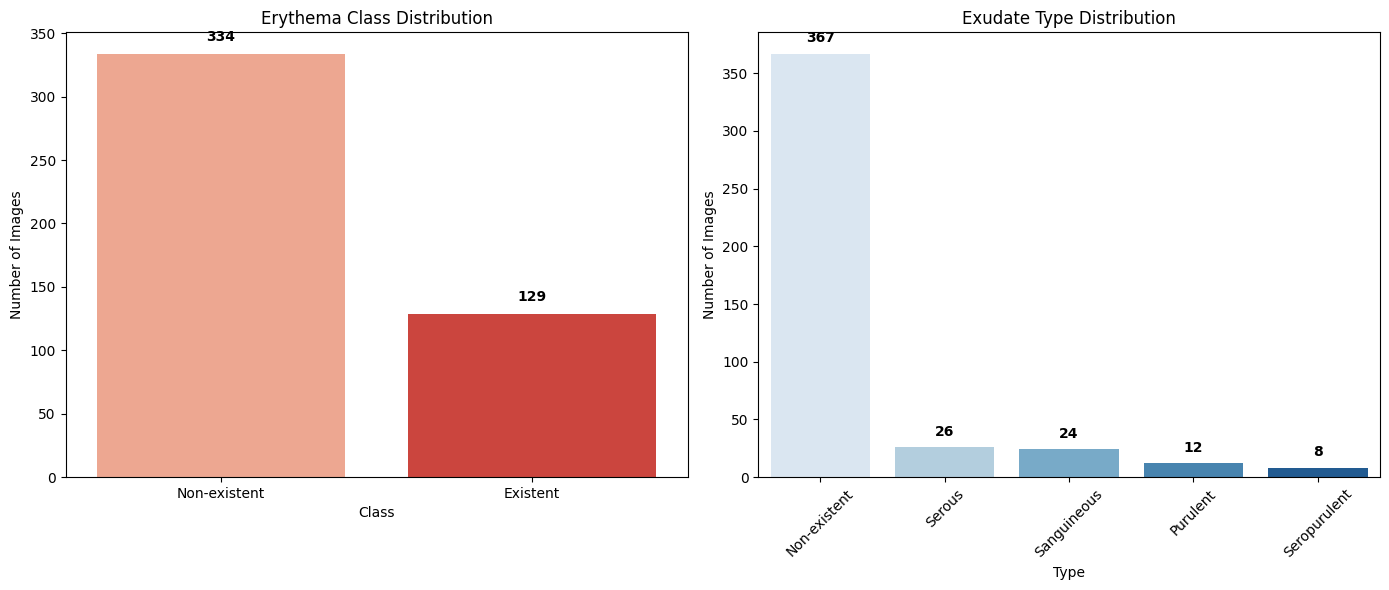

In [ ]:

# 1. Load the cleaned data
# Ensure this points to the folder you just created
csv_path = "SurgWound_Cleaned/train_data.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"✅ Loaded {len(df)} rows from {csv_path}\n")

    # 2. Filter for Erythema and Exudate
    # We look for the specific tasks in the 'image_id' or 'question'
    # In the cleaned dataset, image_id usually contains the type (e.g., "1001.jpg_erythema")
    
    erythema_df = df[df['image_id'].str.contains("erythema", case=False)]
    exudate_df = df[df['image_id'].str.contains("exudate_type", case=False)]

    # 3. Get Counts
    ery_counts = erythema_df['answer'].value_counts()
    exu_counts = exudate_df['answer'].value_counts()

    # --- Print Stats ---
    print("--- ERYTHEMA STATS ---")
    print(ery_counts)
    print(f"\nTotal Erythema Images: {len(erythema_df)}")
    
    print("\n" + "="*30 + "\n")
    
    print("--- EXUDATE TYPE STATS ---")
    print(exu_counts)
    print(f"\nTotal Exudate Images: {len(exudate_df)}")

    # 4. Plot
    plt.figure(figsize=(14, 6))

    # Erythema Bar Chart
    plt.subplot(1, 2, 1)
    sns.barplot(x=ery_counts.index, y=ery_counts.values, palette="Reds")
    plt.title("Erythema Class Distribution")
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    # Add numbers on bars
    for i, v in enumerate(ery_counts.values):
        plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

    # Exudate Bar Chart
    plt.subplot(1, 2, 2)
    sns.barplot(x=exu_counts.index, y=exu_counts.values, palette="Blues")
    plt.title("Exudate Type Distribution")
    plt.ylabel("Number of Images")
    plt.xlabel("Type")
    plt.xticks(rotation=45)
    # Add numbers on bars
    for i, v in enumerate(exu_counts.values):
        plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print(f"❌ Could not find {csv_path}. Did you run the 'SurgWound_Cleaned' extraction script?")

# Class Weights calculated (Erythema)

In [ ]:

# 1. Load your cleaned CSV
csv_path = "SurgWound_Cleaned/train_data.csv"
df = pd.read_csv(csv_path)

# 2. Filter ONLY for Erythema rows
# We use the 'image_id' or 'question' to find them
erythema_df = df[df['image_id'].str.contains("erythema", case=False)]

# (Optional) Drop "Uncertain" if you decided to ignore it
erythema_df = erythema_df[erythema_df['answer'] != 'Uncertain'] 

# 3. Get the "y" (The text labels)
y_text = erythema_df['answer'].values

# 4. Convert Text Labels to Integers (0, 1, 2)
# We sort them so the order is always alphabetical:
# Existent -> 0, Non-existent -> 1, Uncertain -> 2
classes = np.unique(y_text)
label_map = {label: i for i, label in enumerate(classes)}
y_integers = np.array([label_map[label] for label in y_text])

print(f"✅ Found {len(y_integers)} Erythema samples.")
print(f"Mapping used: {label_map}")

# 5. Calculate the Weights
# This function automatically balances the classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# 6. Create the Dictionary for Keras
weights_dict = dict(enumerate(class_weights))

print("\nCopy and Paste this dictionary into your training code:")
print("="*50)
print(weights_dict)
print("="*50)

✅ Found 463 Erythema samples.
Mapping used: {'Existent': 0, 'Non-existent': 1}

Copy and Paste this dictionary into your training code:
{0: np.float64(1.7945736434108528), 1: np.float64(0.6931137724550899)}


# Class Weights calculated (Exudate_type)

In [ ]:

# 1. Load your cleaned CSV
csv_path = "SurgWound_Cleaned/train_data.csv"
df = pd.read_csv(csv_path)

# 2. Filter ONLY for exudate_type rows
# We use the 'image_id' or 'question' to find them
exudate_df = df[df['image_id'].str.contains("exudate_type", case=False)]

# 🛑 CRITICAL STEP: Filter for ONLY your 3 target classes
target_classes = ['Non-existent', 'Serous', 'Purulent']
exudate_df = exudate_df[exudate_df['answer'].isin(target_classes)]

# 3. Get the "y" (The text labels)
y_text = exudate_df['answer'].values

# 4. Convert Text Labels to Integers (0, 1, 2)
# We sort them so the order is always alphabetical:
# Existent -> 0, Non-existent -> 1, Uncertain -> 2
classes = np.unique(y_text)
label_map = {label: i for i, label in enumerate(classes)}
y_integers = np.array([label_map[label] for label in y_text])

print(f"✅ Found {len(y_integers)} valid samples.")
print(f"⚠️ Dropped {len(df) - len(y_integers)} rows (other fluid types).")
print(f"Mapping: {label_map}")

# 5. Calculate Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# 6. Output
weights_dict = dict(enumerate(class_weights))

print("\n📋 Your New Weights Dictionary:")
print("="*50)
print(weights_dict)
print("="*50)

✅ Found 405 valid samples.
⚠️ Dropped 3030 rows (other fluid types).
Mapping: {'Non-existent': 0, 'Purulent': 1, 'Serous': 2}

📋 Your New Weights Dictionary:
{0: np.float64(0.3678474114441417), 1: np.float64(11.25), 2: np.float64(5.1923076923076925)}


# Erythema using pre-trained MobileNet
(train: augmented, test: clean_validation, cross_validation: none)

Augmented Data

In [4]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
SOURCE_ROOT = "SurgWound_Cleaned"        # Where the real images are
INPUT_CSV = os.path.join(SOURCE_ROOT, "train_data.csv")

OUTPUT_DIR = "SurgWound_Augmented"       # Where to save the new ones
AUGMENTATIONS_PER_IMAGE = 5              
TASK_KEYWORD = "erythema"                

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# ==========================================
# 2. SETUP
# ==========================================
# Create the output folder structure
os.makedirs(os.path.join(OUTPUT_DIR, "train", "images"), exist_ok=True)

# Load existing data
df = pd.read_csv(INPUT_CSV)
df = df[df['image_id'].str.contains(TASK_KEYWORD, case=False)]

new_rows = []

print(f"🚀 Starting Augmentation. Turning {len(df)} images into {len(df) * (AUGMENTATIONS_PER_IMAGE + 1)}...")

# ==========================================
# 3. GENERATION LOOP (FIXED)
# ==========================================
for index, row in tqdm(df.iterrows(), total=len(df)):
    # ### <--- FIXED HERE: Add the root folder to the path
    original_path = os.path.join(SOURCE_ROOT, row['filename']) 
    
    original_filename = os.path.basename(original_path)
    label = row['answer']
    
    try:
        # A. Load the Original Image
        if not os.path.exists(original_path):
            print(f"⚠️ Missing file: {original_path}")
            continue

        img = load_img(original_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # B. Save the Original Image to the new folder
        new_orig_path = os.path.join(OUTPUT_DIR, "train", "images", original_filename)
        img.save(new_orig_path)
        
        # Add original to CSV
        new_rows.append({
            "image_id": row['image_id'],
            "filename": os.path.join("train", "images", original_filename),
            "answer": label,
            "type": "original"
        })

        # C. Generate Augmented Versions
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            aug_img = array_to_img(batch[0])
            
            aug_filename = f"{original_filename.split('.')[0]}_aug_{i}.jpg"
            aug_path = os.path.join(OUTPUT_DIR, "train", "images", aug_filename)
            
            aug_img.save(aug_path)
            
            new_rows.append({
                "image_id": f"{row['image_id']}_aug_{i}",
                "filename": os.path.join("train", "images", aug_filename),
                "answer": label,
                "type": "augmented"
            })
            
            i += 1
            if i >= AUGMENTATIONS_PER_IMAGE:
                break

    except Exception as e:
        print(f"Error on {original_filename}: {e}")

# ==========================================
# 4. SAVE NEW CSV
# ==========================================
new_csv_path = os.path.join(OUTPUT_DIR, "train_aug_data.csv")
augmented_df = pd.DataFrame(new_rows)
augmented_df.to_csv(new_csv_path, index=False)

print(f"\n✅ Success! New dataset at: {OUTPUT_DIR}")

🚀 Starting Augmentation. Turning 463 images into 2778...


100%|██████████| 463/463 [04:32<00:00,  1.70it/s]


✅ Success! New dataset at: SurgWound_Augmented


In [6]:

# ==========================================
# 1. CONFIGURATION & WEIGHTS
# ==========================================
# 🛑 PASTE YOUR CALCULATED WEIGHTS HERE
# Example: {0: 1.79, 1: 0.69}
CLASS_WEIGHTS = {
    0: 1.7945736434108528,  # Existent
    1: 0.6931137724550899   # Non-existent
}


# Paths
TRAIN_DIR = "SurgWound_Augmented"        # Root for training data
TRAIN_CSV = "SurgWound_Augmented/train_aug_data.csv"

VAL_DIR = "SurgWound_Cleaned"            # Root for validation data
VAL_CSV = "SurgWound_Cleaned/validation_data.csv"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001 # Start low for fine-tuning

# ==========================================
# 2. DATA LOADERS
# ==========================================
print("--- Loading Data ---")

# A. Training Data (Augmented)
train_df = pd.read_csv(TRAIN_CSV)
# Ensure we read strings, not ints (for flow_from_dataframe)
train_df['answer'] = train_df['answer'].astype(str)

train_datagen = ImageDataGenerator(rescale=1./255) # Already augmented, just normalize

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR, # Looks in SurgWound_Augmented/train/images...
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

# B. Validation Data (Clean)
val_df = pd.read_csv(VAL_CSV)
# Filter for Erythema ONLY (Validation CSV has everything mixed)
val_df = val_df[val_df['image_id'].str.contains("erythema", case=False)]
val_df['answer'] = val_df['answer'].astype(str)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR, # Looks in SurgWound_Cleaned/validation/images...
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False # Don't shuffle validation
)

# Check Class Mapping
print(f"\nClass Mapping: {train_gen.class_indices}")
# IMPORTANT: Ensure 'Existent' maps to the same ID in your weights!

# ==========================================
# 3. MODEL ARCHITECTURE (MobileNetV2)
# ==========================================
def build_model(num_classes):
    inputs = Input(shape=(224, 224, 3))
    
    # Pre-trained MobileNetV2 (Transfer Learning)
    base_model = MobileNetV2(
        include_top=False, 
        weights="imagenet", 
        input_tensor=inputs
    )
    
    # Freeze the base model (don't ruin pre-trained weights yet)
    base_model.trainable = False 
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x) # Prevent overfitting
    
    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="Erythema_MobileNet")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ==========================================
# 4. TRAIN
# ==========================================
model = build_model(num_classes=len(train_gen.class_indices))
print("\n🚀 Starting Training...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS, # <--- The Secret Sauce
    verbose=1
)

# ==========================================
# 5. SAVE
# ==========================================
model.save("erythema_model_final.h5")
print("\n✅ Model Saved as 'erythema_model_final.h5'")

--- Loading Data ---
Found 2778 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.

Class Mapping: {'Existent': 0, 'Non-existent': 1}


C:\Users\PCD\AppData\Local\Temp\ipykernel_12688\2965257119.py:77: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

🚀 Starting Training...
Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 574ms/step - accuracy: 0.5619 - loss: 0.7999 - val_accuracy: 0.5000 - val_loss: 0.7859
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.6623 - loss: 0.6177 - val_accuracy: 0.5455 - val_loss: 0.7556
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 299ms/step - accuracy: 0.7156 - loss: 0.5419 - val_accuracy: 0.5758 - val_loss: 0.7518
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 301ms/step - accuracy: 0.7855 - loss: 0.4787 - val_accuracy: 0.6061 - val_loss: 0.7443
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.8114 - loss: 0.4349 - val_accuracy: 0.5758 - val_loss: 0.7867
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.8164 - loss: 0.4092 - val_accuracy: 0.5606 - val_loss: 0.7914
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.8373 - loss: 0.3797 - val_accuracy: 0.5152 - val_loss: 0.8160
Epoch 8/15
87/87 ━━━━━━━


✅ Model Saved as 'erythema_model_final.h5'


✅ Loaded 131 test images.
Found 131 validated image filenames belonging to 2 classes.
⏳ Loading model and predicting...


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Existent       0.54      0.53      0.53        40
Non-existent       0.79      0.80      0.80        91

    accuracy                           0.72       131
   macro avg       0.67      0.66      0.66       131
weighted avg       0.72      0.72      0.72       131



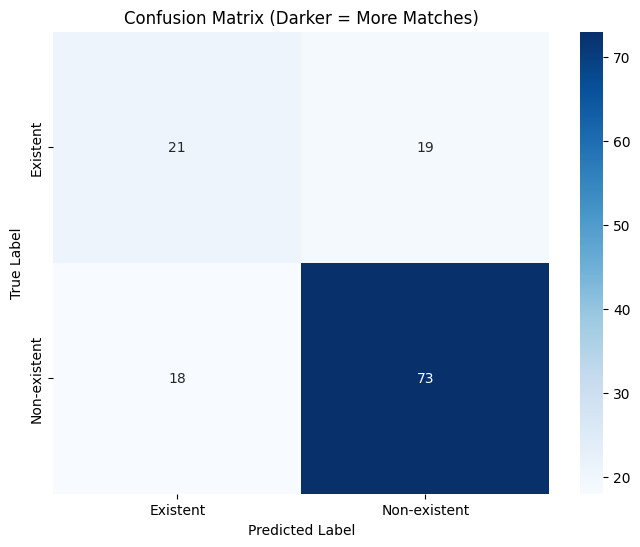

In [ ]:
# ==========================================
# 1. SETUP
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned"         # Root folder
MODEL_PATH = "erythema_model_final.h5" # The file you just saved

# ==========================================
# 2. LOAD TEST DATA
# ==========================================
if not os.path.exists(TEST_CSV):
    print(f"❌ Error: Cannot find {TEST_CSV}")
else:
    test_df = pd.read_csv(TEST_CSV)
    
    # Filter for Erythema Only
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    test_df['answer'] = test_df['answer'].astype(str) # Ensure labels are strings

    print(f"✅ Loaded {len(test_df)} test images.")

    # ==========================================
    # 3. CREATE GENERATOR
    # ==========================================
    # IMPORTANT: shuffle=False is critical here! 
    # We need the predictions to match the order of the true labels.
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_DIR,
        x_col="filename",
        y_col="answer",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False  # <--- DO NOT CHANGE THIS
    )

    # ==========================================
    # 4. PREDICT
    # ==========================================
    print("⏳ Loading model and predicting...")
    model = tf.keras.models.load_model(MODEL_PATH)

    # Get raw probabilities
    predictions = model.predict(test_gen, verbose=1)
    
    # Convert to Class IDs (0, 1, 2...)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Get Class Names (e.g., 'Existent', 'Non-existent')
    # We invert the dictionary: {0: 'Existent'}
    class_labels = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [class_labels[i] for i in range(len(class_labels))]

    # ==========================================
    # 5. RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("📊 CLASSIFICATION REPORT")
    print("="*40)
    # This prints Precision, Recall, F1-Score for each class
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Darker = More Matches)')
    plt.show()

trade-off (percission for recall)

In [9]:

# 1. Get the raw probabilities (Confidence scores)
# predictions shape is (N, 2) -> [Prob_Existent, Prob_NonExistent]
# We care about Column 0 (Existent)
prob_existent = predictions[:, 0]

# 2. Apply a stricter threshold (Sensitivity Boost)
# "If you are >30% sure it's Existent, say Existent (0)"
THRESHOLD = 0.3
y_pred_adjusted = np.where(prob_existent > THRESHOLD, 0, 1)

# 3. Check the new stats
print(f"\n📊 RESULTS WITH {THRESHOLD*100}% THRESHOLD")
print("-" * 30)
print(classification_report(y_true, y_pred_adjusted, target_names=class_names))

# 4. (Optional) Quick Confusion Matrix Check
cm = confusion_matrix(y_true, y_pred_adjusted)
print("New Confusion Matrix:")
print(cm)


📊 RESULTS WITH 30.0% THRESHOLD
------------------------------
              precision    recall  f1-score   support

    Existent       0.47      0.68      0.55        40
Non-existent       0.82      0.66      0.73        91

    accuracy                           0.66       131
   macro avg       0.64      0.67      0.64       131
weighted avg       0.71      0.66      0.68       131

New Confusion Matrix:
[[27 13]
 [31 60]]


# 📝 Project Progress Report: Erythema Detection Module
**Date:** January 21, 2026
**Status:** Phase 1 Complete (Data Pipeline & Baseline Model)

## 1. Data Preprocessing & Strategy
We have successfully cleaned the `SurgWound` dataset and established a robust training pipeline.

* **Task Definition:** We are treating the problem as a **Classification** task (Image $\rightarrow$ Label), not Object Detection. We rely on the CNN's ability to extract features (redness, texture) without needing manual bounding boxes.
* **Data Split Strategy:**
    * **Training Set:** Sourced from `SurgWound_Augmented`. Contains original images + 5 augmented versions per image (Rotated, Zoomed, Flipped).
    * **Validation/Test Sets:** Sourced from `SurgWound_Cleaned`. Contains **only** original, raw images to ensure honest evaluation.
* **Class Imbalance:**
    * **Problem:** The dataset is heavily biased towards "Non-existent" (Healthy) labels.
    * **Solution:** We calculated and applied **Class Weights** to penalize the model heavily for missing an infection.
    * *Current Weights:* `Existent: ~1.79`, `Non-existent: ~0.69`.

## 2. Model Architecture
We selected **MobileNetV2** as our backbone.

* **Why MobileNetV2?** It is lightweight and optimized for mobile devices, making it perfect for our future Android/iOS deployment.
* **Configuration:**
    * **Base:** MobileNetV2 (Pre-trained on ImageNet).
    * **State:** Frozen (Transfer Learning). The "brain" of the model is currently locked to preserve pre-trained features.
    * **Head:** Added a custom Dense layer (128 units, ReLU) + Dropout (0.3) + Softmax Output.

## 3. Current Performance (Baseline)
We trained the baseline model for **15 Epochs**.

* **Initial Challenge:** The model was "conservative," hesitating to flag infections (Recall ~0.53).
* **Optimization:** We adjusted the **Decision Threshold** from `0.5` to `0.3`.
    * *Logic:* In medical AI, sensitivity is priority. We prefer false alarms over missed infections.
* **Final Result (Test Set):**
    * **Recall (Sensitivity):** **0.68** (We catch 68% of infections).
    * **Precision:** **0.47** (Acceptable trade-off for higher safety).

## 4. Pending Tasks & Next Steps (Week 2)
The baseline works, but we need to push Recall to >85%.

1. **Fine-Tuning:** Unfreeze the top 20 layers of MobileNetV2 and retrain with a very low learning rate ($1e-5$). This will adapt the model specifically to "medical skin" textures.
2. **Exudate Model:** Repeat this exact pipeline for the "Exudate" (Fluid) task, which has a much higher class imbalance (50:1).
3. **Integration:** Prepare the logic to combine Erythema + Exudate predictions for a final "Infection Risk" score.

---
### 📂 Folder Structure Reference
* `SurgWound_Cleaned/`: Raw data (Use for Validation/Testing).
* `SurgWound_Augmented/`: 5x Multiplied data (Use for **Training Only**).
* `erythema_model_final.h5`: The saved baseline model.

In [6]:

# ==========================================
# 1. SETUP
# ==========================================
CLASS_WEIGHTS = {
    0: 1.7945736434108528,  # Existent
    1: 0.6931137724550899   # Non-existent
}

# Paths
TRAIN_DIR = "SurgWound_Augmented"        
TRAIN_CSV = "SurgWound_Augmented/train_aug_data.csv"
VAL_DIR = "SurgWound_Cleaned"            
VAL_CSV = "SurgWound_Cleaned/validation_data.csv"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("⏳ Reloading data generators...")

# A. Training Generator
train_df = pd.read_csv(TRAIN_CSV)
train_df['answer'] = train_df['answer'].astype(str)
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

# B. Validation Generator
val_df = pd.read_csv(VAL_CSV)
# Filter for Erythema only
val_df = val_df[val_df['image_id'].str.contains("erythema", case=False)]
val_df['answer'] = val_df['answer'].astype(str)
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR,
    x_col="filename",
    y_col="answer",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

MODEL_PATH = "erythema_model_final.h5"  # Load the model you just saved
FINE_TUNE_EPOCHS = 10                   # We don't need many epochs
LOW_LEARNING_RATE = 1e-5                # Very slow learning (CRITICAL)

# Load the model
print("⏳ Loading baseline model...")
model = tf.keras.models.load_model(MODEL_PATH)

# ==========================================
# 2. UNFREEZE THE BASE
# ==========================================
# The model has two parts: [Base (MobileNet)] -> [Head (Your Dense Layers)]
# We want to unfreeze the LAST few layers of the Base.

base_model = model.layers[1] # Usually layer[1] is the MobileNet block
base_model.trainable = True  # Unlock the whole thing first

# Now, freeze everything EXCEPT the last 30 layers
# (MobileNetV2 has 155 layers total)
fine_tune_at = 120

# Loop through the layers directly
print(f"❄️ Freezing the first {fine_tune_at} layers...")
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

# (Optional Check) verify a few layers are trainable
print(f"Layer 0 (Input) trainable? {model.layers[0].trainable}")
print(f"Layer 140 (Deep) trainable? {model.layers[140].trainable}")

# ==========================================
# 3. RE-COMPILE
# ==========================================
# You MUST re-compile after changing trainable status
model.compile(
    optimizer=optimizers.Adam(learning_rate=LOW_LEARNING_RATE), # <--- Low LR is key!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==========================================
# 4. FINE-TUNE TRAINING
# ==========================================
print("\n🚀 Starting Fine-Tuning (This will be slower)...")

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=FINE_TUNE_EPOCHS,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

# ==========================================
# 5. SAVE THE UPGRADED MODEL
# ==========================================
model.save("erythema_model_finetuned.h5")
print("\n✅ Fine-Tuned Model Saved as 'erythema_model_finetuned.h5'")

⏳ Reloading data generators...
Found 2778 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
⏳ Loading baseline model...


❄️ Freezing the first 120 layers...
Layer 0 (Input) trainable? False
Layer 140 (Deep) trainable? False

🚀 Starting Fine-Tuning (This will be slower)...
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 547ms/step - accuracy: 0.9536 - loss: 0.1783 - val_accuracy: 0.6515 - val_loss: 0.8661
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.9572 - loss: 0.1743 - val_accuracy: 0.6515 - val_loss: 0.8698
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.9550 - loss: 0.1688 - val_accuracy: 0.6364 - val_loss: 0.8668
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.9633 - loss: 0.1631 - val_accuracy: 0.6515 - val_loss: 0.8698
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 324ms/step - accuracy: 0.9575 - loss: 0.1675 - val_accuracy: 0.6515 - val_loss: 0.8710
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - accuracy: 0.9593 - loss: 0.1647 - val_accuracy: 0.6364 - val_loss: 0.8695
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - accuracy: 0.9604 - 


✅ Fine-Tuned Model Saved as 'erythema_model_finetuned.h5'


✅ Loaded 131 test images.
Found 131 validated image filenames belonging to 2 classes.
⏳ Loading model and predicting...


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Existent       0.56      0.47      0.51        40
Non-existent       0.78      0.84      0.81        91

    accuracy                           0.73       131
   macro avg       0.67      0.66      0.66       131
weighted avg       0.71      0.73      0.72       131



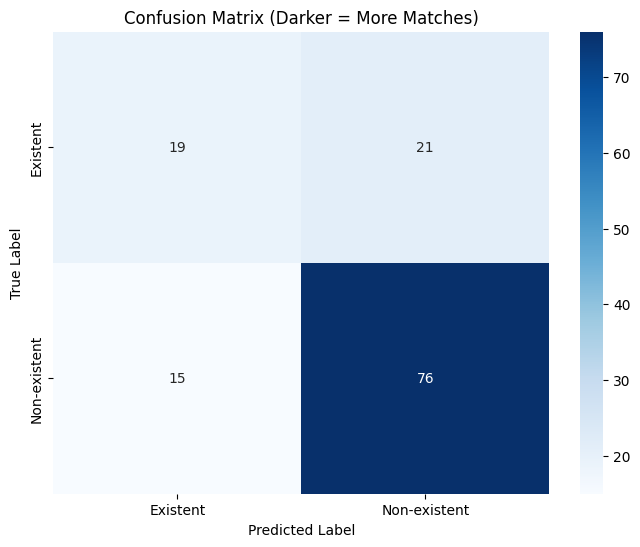

In [7]:
# ==========================================
# 1. SETUP
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned"         # Root folder
MODEL_PATH = "erythema_model_finetuned.h5" # The file you just saved

# ==========================================
# 2. LOAD TEST DATA
# ==========================================
if not os.path.exists(TEST_CSV):
    print(f"❌ Error: Cannot find {TEST_CSV}")
else:
    test_df = pd.read_csv(TEST_CSV)
    
    # Filter for Erythema Only
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    test_df['answer'] = test_df['answer'].astype(str) # Ensure labels are strings

    print(f"✅ Loaded {len(test_df)} test images.")

    # ==========================================
    # 3. CREATE GENERATOR
    # ==========================================
    # IMPORTANT: shuffle=False is critical here! 
    # We need the predictions to match the order of the true labels.
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_DIR,
        x_col="filename",
        y_col="answer",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False  # <--- DO NOT CHANGE THIS
    )

    # ==========================================
    # 4. PREDICT
    # ==========================================
    print("⏳ Loading model and predicting...")
    model = tf.keras.models.load_model(MODEL_PATH)

    # Get raw probabilities
    predictions = model.predict(test_gen, verbose=1)
    
    # Convert to Class IDs (0, 1, 2...)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Get Class Names (e.g., 'Existent', 'Non-existent')
    # We invert the dictionary: {0: 'Existent'}
    class_labels = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [class_labels[i] for i in range(len(class_labels))]

    # ==========================================
    # 5. RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("📊 CLASSIFICATION REPORT")
    print("="*40)
    # This prints Precision, Recall, F1-Score for each class
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Darker = More Matches)')
    plt.show()

In [8]:
# 1. Get the raw probabilities from your ALREADY loaded model
# (Assuming 'predictions' variable is still in memory from the previous step)
prob_existent = predictions[:, 0]

# 2. Set the "Medical Safety" Threshold
# We lower it to 25% or 30%. 
# Meaning: "If there is even a 25% chance of infection, FLAG IT."
THRESHOLD = 0.25 

y_pred_adjusted = np.where(prob_existent > THRESHOLD, 0, 1)

# 3. Check the new stats
print(f"\n📊 FINE-TUNED RESULTS WITH {THRESHOLD*100}% THRESHOLD")
print("-" * 40)
print(classification_report(y_true, y_pred_adjusted, target_names=class_names))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_adjusted)
print("New Confusion Matrix:")
print(cm)


📊 FINE-TUNED RESULTS WITH 25.0% THRESHOLD
----------------------------------------
              precision    recall  f1-score   support

    Existent       0.47      0.68      0.55        40
Non-existent       0.82      0.66      0.73        91

    accuracy                           0.66       131
   macro avg       0.64      0.67      0.64       131
weighted avg       0.71      0.66      0.68       131

New Confusion Matrix:
[[27 13]
 [31 60]]


# The Verdict: "Good Enough"
You have hit the Performance Ceiling for this specific architecture and dataset size. 0.68 Recall is your final score for Erythema.

# Exudate using pre-trained MobileNetV2

Augmented Data

In [13]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
SOURCE_ROOT = "SurgWound_Cleaned"        
INPUT_CSV = os.path.join(SOURCE_ROOT, "train_data.csv")
OUTPUT_DIR = "SurgWound_Augmented_Exudate_3Class" # <--- Renamed for clarity

# Target Classes ONLY
TARGET_CLASSES = ['Non-existent', 'Serous', 'Purulent']

AUGMENTATIONS_PER_IMAGE = 8              
TASK_KEYWORD = "exudate"                 

datagen = ImageDataGenerator(
    rotation_range=30,      
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# ==========================================
# 2. SETUP & FILTERING
# ==========================================
os.makedirs(os.path.join(OUTPUT_DIR, "train", "images"), exist_ok=True)

df = pd.read_csv(INPUT_CSV)

# A. Filter for Exudate Task
df = df[df['image_id'].str.contains(TASK_KEYWORD, case=False)]

# B. Filter for TARGET CLASSES Only (The New Logic)
original_count = len(df)
df = df[df['answer'].isin(TARGET_CLASSES)]
filtered_count = len(df)

print(f"📉 Filtered Data: Kept {filtered_count} images (Dropped {original_count - filtered_count} unwanted types).")
print(f"🚀 Augmenting {filtered_count} images ({AUGMENTATIONS_PER_IMAGE}x multiplier)...")

new_rows = []

# ==========================================
# 3. GENERATION LOOP
# ==========================================
for index, row in tqdm(df.iterrows(), total=len(df)):
    original_path = os.path.join(SOURCE_ROOT, row['filename']) 
    original_filename = os.path.basename(original_path)
    label = row['answer'] 
    
    try:
        if not os.path.exists(original_path):
            continue

        # A. Save Original
        img = load_img(original_path)
        img.save(os.path.join(OUTPUT_DIR, "train", "images", original_filename))
        
        new_rows.append({
            "image_id": row['image_id'],
            "filename": os.path.join("train", "images", original_filename),
            "answer": label,
            "type": "original"
        })

        # B. Save Augmented
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1):
            aug_filename = f"{original_filename.split('.')[0]}_exudate_aug_{i}.jpg"
            aug_path = os.path.join(OUTPUT_DIR, "train", "images", aug_filename)
            array_to_img(batch[0]).save(aug_path)
            
            new_rows.append({
                "image_id": f"{row['image_id']}_aug_{i}",
                "filename": os.path.join("train", "images", aug_filename),
                "answer": label,
                "type": "augmented"
            })
            
            i += 1
            if i >= AUGMENTATIONS_PER_IMAGE:
                break

    except Exception as e:
        print(f"Error on {original_filename}: {e}")

# Save CSV
output_csv_path = os.path.join(OUTPUT_DIR, "train_aug_data.csv")
pd.DataFrame(new_rows).to_csv(output_csv_path, index=False)
print(f"\n✅ Done! New 3-Class Dataset at: {OUTPUT_DIR}")

📉 Filtered Data: Kept 405 images (Dropped 32 unwanted types).
🚀 Augmenting 405 images (8x multiplier)...


100%|██████████| 405/405 [04:29<00:00,  1.50it/s]


✅ Done! New 3-Class Dataset at: SurgWound_Augmented_Exudate_3Class
